# Comparing a USGSCSM and ISIS camera for Dawn FC

In [1]:
import pvl
import numpy as np
import os
os.environ['ISISROOT'] = '/usgs/pkgs/isis3.7.1/install/'
os.environ['PROJ_LIB'] = '/work/users/acpaquette/miniconda3/envs/ale_env/share/proj' #point to you local environment path

import pandas as pd
import knoten
import csmapi
import pyproj

import plotly
plotly.io.orca.config.use_xvfb = False
plotly.io.orca.config.save()

from knoten import vis

from pysis import isis
from pysis.exceptions import ProcessError

from IPython.display import Image

## Make a CSM sensor model

In [2]:
imageLink = 'https://pdsimage.wr.usgs.gov/Missions/Dawn/Ceres/DWNCSFC2_1A/DATA/IMG/20150604_SURVEY/20150617_CYCLE5/FC21A0038582_15170161546F6F.IMG'
!wget -N -P data/ {imageLink}
fileName = 'data/' + os.path.split(imageLink)[1]

camera = knoten.csm.create_csm(fileName)
camera

--2019-08-02 15:37:01--  https://pdsimage.wr.usgs.gov/Missions/Dawn/Ceres/DWNCSFC2_1A/DATA/IMG/20150604_SURVEY/20150617_CYCLE5/FC21A0038582_15170161546F6F.IMG
Resolving pdsimage.wr.usgs.gov (pdsimage.wr.usgs.gov)... 8.27.177.76
Connecting to pdsimage.wr.usgs.gov (pdsimage.wr.usgs.gov)|8.27.177.76|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘data/FC21A0038582_15170161546F6F.IMG’ not modified on server. Omitting download.



<csmapi.csmapi.RasterGM; proxy of <Swig Object of type 'csm::RasterGM *' at 0x7f0f183137b0> >

## Ingest the image and spiceinit

In [3]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.dawnfc2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ELLIPSOID')
except ProcessError as e:
    print(e.stderr)

## Define a function that compares ISIS and USGSCSM pixels

In [4]:
def check_pixel_isis_ground(camera, cub, line, sample):
    """Compares ISIS and USGSCSM pixel.
    
    Takes an image coordinate, projects it to a ground point using ISIS, then projects
    the result back into an image coordinate using USGSCSM and computes the difference
    between image coordinates.
    """
    try:
        output = isis.campt(from_=cub, line=line, sample=sample, allowoutside='Yes')
    except ProcessError as e:
        print(e.stderr)
        return np.NaN, np.NaN
    pvl_output = pvl.loads(output)
    bodyfixed = pvl_output['GroundPoint']['BodyFixedCoordinate']
    bodyfixed = np.asarray(bodyfixed.value) * 1000
    image_coord = camera.groundToImage(csmapi.EcefCoord(*bodyfixed))
    # (.5,.5) in CSM == (1,1) in ISIS, so we have to subtract (.5,.5) from the ISIS pixels
    line_diff = line - image_coord.line - .5
    sample_diff = sample - image_coord.samp - .5
    return line_diff, sample_diff

def check_pixel_csm_ground(camera, cub, line, sample):
    """Compares USGSCSM pixel to ISIS.
    
    Takes an image coordinate, projects it to a ground point using CSM, then projects
    the result back into an image coordinate using ISIS and computes the difference
    between image coordinates.
    """
    image_coord = csmapi.ImageCoord(line, sample)
    ecef_coord = camera.imageToGround(image_coord, 0.0)
    
    def ecef_to_lla(camera, ecef_coord):
        semi_major, semi_minor = knoten.csm.get_radii(camera)
        ecef = pyproj.Proj(proj='geocent', a=semi_major, b=semi_minor)
        lla = pyproj.Proj(proj='latlong', a=semi_major, b=semi_minor)
        lon, lat, alt = pyproj.transform(ecef, lla, ecef_coord.x, ecef_coord.y, ecef_coord.z)
        return lon, lat, alt
    
    lon, lat, _ = ecef_to_lla(camera, ecef_coord)
    try:
        output = isis.campt(from_=cub, type='ground', latitude=lat, longitude=lon, allowoutside='Yes')
        pvl_output = pvl.loads(output)
        isis_line = pvl_output['GroundPoint']['Line']
        isis_sample = pvl_output['GroundPoint']['Sample']
    except ProcessError as e:
        print(e)
        isis_line = np.NaN
        isis_sample = np.NaN
    # (.5,.5) in CSM == (1,1) in ISIS, so we have to add (.5,.5) from the ISIS pixels
    line_diff = isis_line - image_coord.line + .5
    sample_diff = isis_sample - image_coord.samp + .5
    return line_diff, sample_diff

In [5]:
def check_orientation(camera, cub, line, sample):
    try:
        output = isis.campt(from_=cub, line=line, sample=sample)
    except ProcessError as e:
        print(e.stderr)
        return [np.NaN, np.NaN, np.NaN], [np.NaN, np.NaN, np.NaN]
    pvl_output = pvl.loads(output)
    isis_position = np.array(pvl_output['GroundPoint']['SpacecraftPosition'].value) * 1000
    isis_look = np.array(pvl_output['GroundPoint']['LookDirectionBodyFixed'])
    csm_locus = camera.imageToRemoteImagingLocus(csmapi.ImageCoord(line - 0.5, sample - 0.5))
    csm_position = np.array([csm_locus.point.x, csm_locus.point.y, csm_locus.point.z])
    csm_look = np.array([csm_locus.direction.x, csm_locus.direction.y, csm_locus.direction.z])
    diff_position = isis_position - csm_position
    diff_look = isis_look - csm_look
    return diff_position, diff_look

## Get the total number of lines / samples

In [6]:
isis_label = pvl.load(cub_loc)
n_samples = isis_label['IsisCube']['Core']['Dimensions']['Samples']
n_lines = isis_label['IsisCube']['Core']['Dimensions']['Lines']

## Compare top left, top right, bottom left, bottom right, and center pixels using check_pixel

In [7]:
pixels_dict = {'line' : [0,0,n_lines, n_lines, n_lines/2],
               'sample' : [0, n_samples, 0, n_samples, n_samples/2]}

pixels_df = pd.DataFrame.from_dict(pixels_dict)
pixels_df['line_diff'] = np.NaN
pixels_df['sample_diff'] = np.NaN
pixels_df['pos_x_diff'] = np.NaN
pixels_df['pos_y_diff'] = np.NaN
pixels_df['pos_z_diff'] = np.NaN
pixels_df['look_x_diff'] = np.NaN
pixels_df['look_y_diff'] = np.NaN
pixels_df['look_z_diff'] = np.NaN

for idx, row in pixels_df.iterrows():
    pixels_df.iloc[idx]['line_diff'], pixels_df.iloc[idx]['sample_diff'] = check_pixel_isis_ground(camera, cub_loc, row['line'], row['sample'])
    diff_position, diff_look = check_orientation(camera, cub_loc, row['line'], row['sample'])
    pixels_df.iloc[idx]['pos_x_diff'] = diff_position[0]
    pixels_df.iloc[idx]['pos_y_diff'] = diff_position[1]
    pixels_df.iloc[idx]['pos_z_diff'] = diff_position[2]
    pixels_df.iloc[idx]['look_x_diff'] = diff_look[0]
    pixels_df.iloc[idx]['look_y_diff'] = diff_look[1]
    pixels_df.iloc[idx]['look_z_diff'] = diff_look[2]

pixels_df

,line,sample,line_diff,sample_diff,pos_x_diff,pos_y_diff,pos_z_diff,look_x_diff,look_y_diff,look_z_diff
0,0.0,0.0,-0.772510,0.055979,-128.20655,788.593427,-184.582953,-0.040271,-0.025477,-0.003050
1,0.0,1024.0,-1.232304,-0.333093,-128.20655,788.593427,-184.582953,0.040187,0.025407,0.000771
2,1024.0,0.0,-0.546682,0.515027,-128.20655,788.593427,-184.582953,-0.040212,-0.025654,-0.003041
3,1024.0,1024.0,-1.000933,0.128860,-128.20655,788.593427,-184.582953,0.040246,0.025231,0.000780
4,512.0,512.0,-0.929283,0.072629,-128.20655,788.593427,-184.582953,-0.000061,-0.000133,-0.000004


## Generate a more detailed comparison
The level of detailed can be changed through the nx and ny variables in the reprojection_diff function

In [8]:
csm_isd = os.path.splitext(fileName)[0] + '.json'

csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

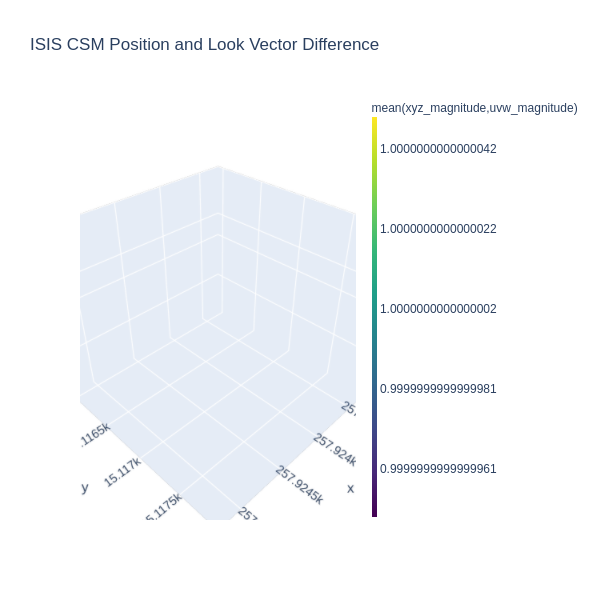

In [9]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

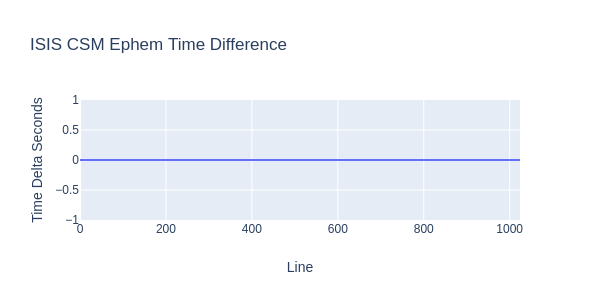

In [10]:
Image(csmisis_diff_ephem_plot_bytes)

In [11]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,128.20655,-788.593427,184.582953,0.004032,0.002651,0.000579
std,0.00000,0.000000,0.000000,0.023167,0.014654,0.001273
min,128.20655,-788.593427,184.582953,-0.032264,-0.020328,-0.000805
25%,128.20655,-788.593427,184.582953,-0.016119,-0.010101,-0.000581
50%,128.20655,-788.593427,184.582953,0.004050,0.002654,0.000215
75%,128.20655,-788.593427,184.582953,0.024195,0.015409,0.001560
max,128.20655,-788.593427,184.582953,0.040271,0.025629,0.003052


In [12]:
isis2csm_plot, csm2isis_plot, isiscsm_latlonplot, isiscsm_bfplot, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, nx=8, ny=8)

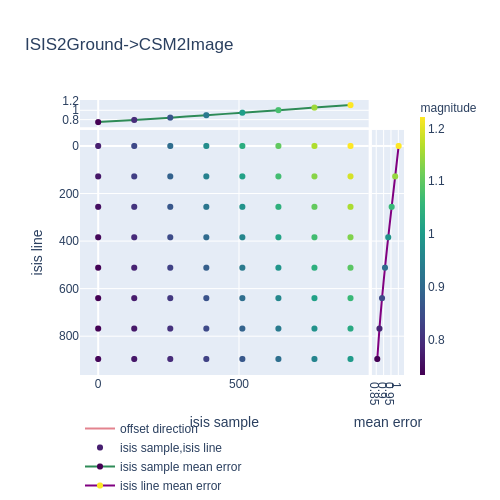

In [13]:
Image(isis2csm_plot.to_image())

In [14]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,64.000000,64.000000
mean,-0.902189,0.074138
std,0.150087,0.174360
min,-1.186912,-0.289843
25%,-1.017034,-0.047860
50%,-0.902227,0.068652
75%,-0.778547,0.193280
max,-0.584084,0.453413


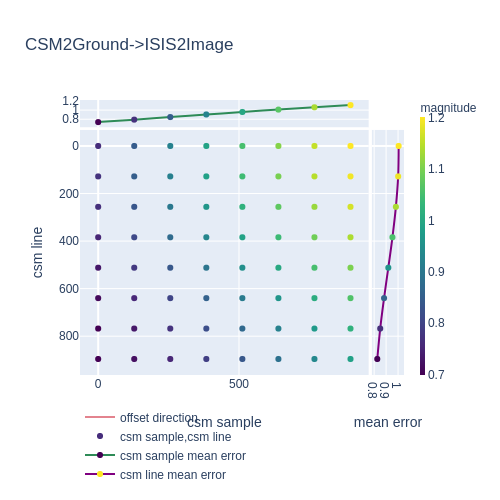

In [15]:
Image(csm2isis_plot.to_image())

In [16]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,64.000000,64.000000
mean,0.907818,-0.071802
std,0.156929,0.162474
min,0.561562,-0.415752
25%,0.784973,-0.185089
50%,0.917361,-0.082328
75%,1.040019,0.039505
max,1.169088,0.308688


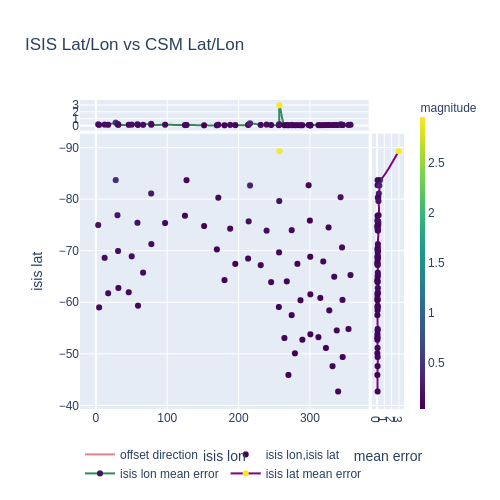

In [17]:
Image(isiscsm_latlonplot.to_image())

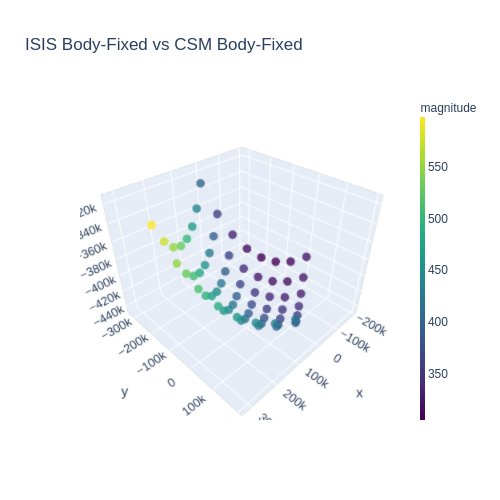

In [18]:
Image(isiscsm_bfplot.to_image())

In [19]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,64.000000,64.000000,64.000000
mean,-0.276297,304.724976,-107.418715
std,0.272169,92.206269,98.283782
min,-0.668785,104.644265,-285.796069
25%,-0.488276,237.846024,-177.795534
50%,-0.326865,306.278414,-100.699345
75%,-0.110702,370.552001,-29.804092
max,0.680405,498.686331,84.691849
